In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d "abhayayare/multi-turn-chatbot-conversation-dataset"

In [ ]:
!unzip /content/multi-turn-chatbot-conversation-dataset.zip

In [1]:
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.keras import layers, models, callbacks, utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('/content/archive/chatbot_conversations.csv')

In [4]:
train_df.head()

,conversation_id,turn,role,intent,message
0,a73b5331-1a84-4ade-9e72-0889584b220b,1.0,user,shopping,best deals today?
1,a73b5331-1a84-4ade-9e72-0889584b220b,1.5,bot,shopping,"Sure, let me help you with that!"
2,a73b5331-1a84-4ade-9e72-0889584b220b,2.0,user,ai,what is llm?
3,a73b5331-1a84-4ade-9e72-0889584b220b,2.5,bot,ai,"Sure, let me help you with that!"
4,a73b5331-1a84-4ade-9e72-0889584b220b,3.0,user,habits,good habits?


In [5]:
train_df.columns

Index(['conversation_id', 'turn', 'role', 'intent', 'message'], dtype='object')

In [6]:
train_df = train_df.drop(['conversation_id', 'turn', 'role'], axis=1)

In [7]:
train_df.columns

Index(['intent', 'message'], dtype='object')

In [8]:
le = LabelEncoder()

In [9]:
train_df['intent'] = le.fit_transform(train_df['intent'])

In [10]:
num_classes = len(le.classes_)

In [11]:
print(num_classes)

55


In [12]:
word_counts = train_df['message'].str.split().str.len()
avg_len = word_counts.mean()
max_len = word_counts.max()
median_len = word_counts.median()

print(f"Average length: {avg_len}")
print(f"Maximum length: {max_len}")
print(f"Median length: {median_len}")

Average length: 4.926705739866976
Maximum length: 7
Median length: 5.0


In [14]:
word_counts.quantile([0.9, 0.95, 0.99])

,message
0.90,7.0
0.95,7.0
0.99,7.0


In [15]:
x_train, x_val, y_train, y_val = train_test_split(train_df['message'], train_df['intent'], test_size=0.2, random_state=42, stratify=train_df['intent'].values)

In [16]:
vectorizer = layers.TextVectorization(max_tokens=10000, output_mode="int", output_sequence_length=8)

In [17]:
vectorizer.adapt(x_train)

In [18]:
BATCH_SIZE = 64

In [19]:
train_ds = Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [20]:
vocab_size = 10000
embedding_dim = 128

In [26]:
model = models.Sequential([
  layers.Input(shape=(1,), dtype=tf.string),
  vectorizer,
  layers.Embedding(vocab_size, embedding_dim),
  layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 8)              │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 8, 128)         │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 55)             │         3,575 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,328,951 (5.07 MB)

 Trainable params: 1,328,951 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=1)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[early_stop])

Epoch 1/5
162452/162452 ━━━━━━━━━━━━━━━━━━━━ 4917s 30ms/step - accuracy: 0.5518 - loss: 1.7915 - val_accuracy: 0.5503 - val_loss: 1.7823
Epoch 2/5
162452/162452 ━━━━━━━━━━━━━━━━━━━━ 4967s 31ms/step - accuracy: 0.5546 - loss: 1.7781 - val_accuracy: 0.5548 - val_loss: 1.7776
Epoch 3/5
156256/162452 ━━━━━━━━━━━━━━━━━━━━ 2:54 28ms/step - accuracy: 0.5546 - loss: 1.7781

In [29]:
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

In [30]:
print(f"Train accuracy: {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")

Train accuracy: 0.5545
Validation accuracy: 0.5548


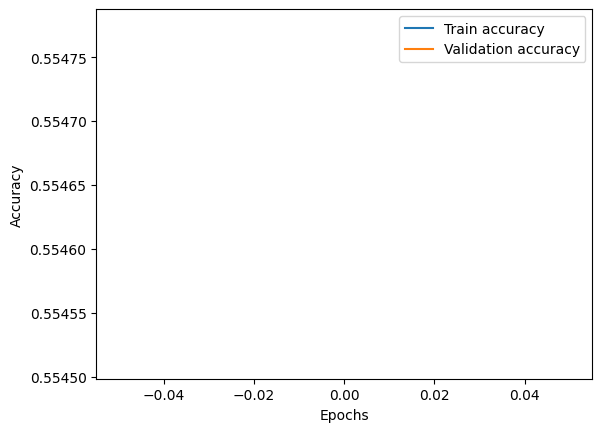

In [31]:
plt.plot(train_acc, label="Train accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [32]:
model.save("text-mind.h5")

In [38]:
pred = model.predict(tf.constant(["Should I eat meal?"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


In [39]:
label_id = np.argmax(pred, axis=1)

In [40]:
main_pred = le.inverse_transform(label_id)

In [41]:
print(main_pred)

['emotions']
